In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import mmcv
from src.utils import  visualization
from src.utils.neptune_utils import load_results
from src.extensions.dataset.coco_otc import count_items
import pandas as pd
from mmcv import Config
from mmdet.datasets import build_dataset, get_loading_pipeline
%matplotlib inline

In [47]:
vfnet_oc = load_results("EV-114", "VFNet")
vfnet_map = load_results("EV-119", "VFNet")

https://app.neptune.ai/mayu-ot/eval-detection/e/EV-114
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
https://app.neptune.ai/mayu-ot/eval-detection/e/EV-119
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


In [18]:
cfg = Config.fromfile(os.path.join("~/.cache/mim/vfnet_r50_fpn_mstrain_2x_coco.py"))
cfg.data.test.type="CocoOtcDataset"
cfg.data.test.test_mode = True
cfg.data.test.pop('samples_per_gpu', 0)
cfg.data.test.pipeline = get_loading_pipeline(cfg.data.train.pipeline)
dataset = build_dataset(cfg.data.test)
gts = dataset.get_gts()

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [48]:
n_dets = {}
n_dets["OC-cost"] = count_items(vfnet_oc)
n_dets["mAP"] = count_items(vfnet_map)
n_dets["GT"] = count_items(gts)

Text(0.5, 8.959999999999994, 'Number of annotated instances')

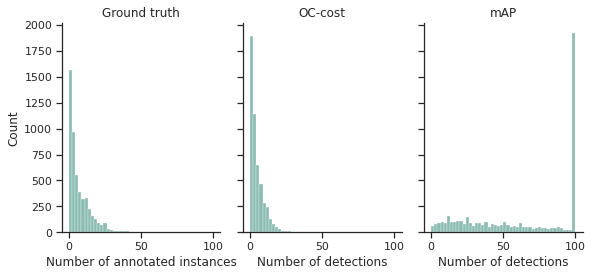

In [33]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
n = len(n_dets["OC-cost"])
cp = sns.cubehelix_palette(rot=-.4)
df = pd.DataFrame({"Number of detections": n_dets["GT"]+n_dets["OC-cost"] + n_dets["mAP"], "t_measure": ["Ground truth"]*n+["OC-cost"]*n + ["mAP"]*n})
g = sns.displot(data=df, col="t_measure", x="Number of detections", color=cp[2], height=4, aspect=0.7)
g.set_titles("{col_name}")
g.axes[0, 0].set_xlabel("Number of annotated instances")
g.savefig("outputs/figs/tuning_on_oc_cost/n_dets_hist.pdf", bbox_inches="tight")

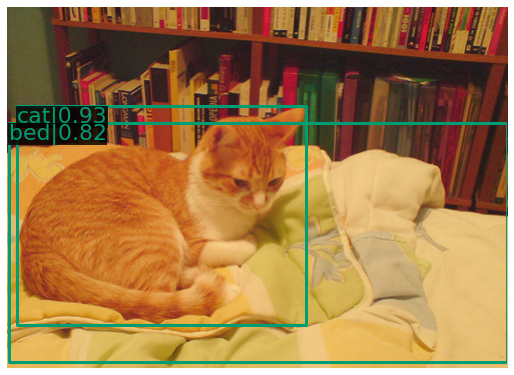

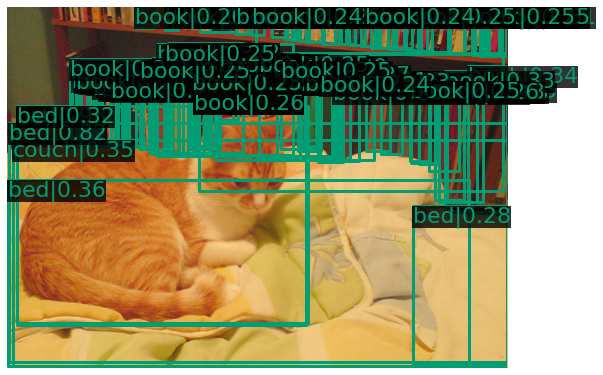

In [46]:
def cvrt_result(bbox_result):
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)
    bboxes = np.vstack(bbox_result)
    return bboxes, labels
cb_p = sns.color_palette("colorblind")
det_c = (np.asarray(cb_p[2])*255).astype(np.uint8)[::-1]

i = np.random.randint(n)
vfnet_oc_dets = vfnet_oc[i]
vfnet_map_dets = vfnet_map[i]
data_info = dataset.prepare_train_img(i)
out_dir = "outputs/figs/tuning_on_oc_cost/"

for i, dets in enumerate([vfnet_oc_dets, vfnet_map_dets]):
    dets, labels = cvrt_result(dets)
    img_id = data_info["img_info"]["id"]
    im = visualization.imshow_det_bboxes(
        data_info["filename"],
        dets,
        labels,
        class_names=dataset.CLASSES,
        bbox_color=det_c,
        text_color=det_c,
        thickness=3,
        font_size=22,
        show=True,
        out_file=f"{out_dir}{img_id}_{i}.pdf")

In [38]:
data_info = dataset.prepare_train_img(20)
data_info.keys()

dict_keys(['img_info', 'ann_info', 'img_prefix', 'seg_prefix', 'proposal_file', 'bbox_fields', 'mask_fields', 'seg_fields', 'filename', 'ori_filename', 'img', 'img_shape', 'ori_shape', 'img_fields', 'gt_bboxes', 'gt_bboxes_ignore', 'gt_labels'])

{'license': 1,
 'file_name': '000000143931.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000143931.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-16 15:38:46',
 'flickr_url': 'http://farm9.staticflickr.com/8474/8145963753_2e334946c7_z.jpg',
 'id': 143931,
 'filename': '000000143931.jpg'}